# Train a machine learning model to identify autophagy-positive cells

The goal of this notebook is to train a ML model to distininguish between autophagy-positive and autophagy-negative cells based on pre-calculated image features.

We have defined our classes as follows:

``Class 0`` : unstimulated WT cells  
``Class 1`` : 14h Torin-1 stimulated WT cells  

After training and evaluating our model we want to see how cells without a functional *EI24* gene (``EI24KO`` cells) compare to ``WT`` cells.

In [1]:
import lamindb as ln
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import scportrait
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
from anndata import concat

def _get_cells(dataframe):
    sc_data = None
    for uid in dataframe.dataset.unique():
        _selected_cells = dataframe[dataframe.dataset == uid].copy()
        _sc_data = scportrait.io.read_h5sc(ln.Artifact.get(uid).cache())
        _sc_data = _sc_data[_sc_data.obs.cell_id.isin(_selected_cells.cell_id.values)]
        _sc_data.obs["score"] = _selected_cells.prob_class1.values

        if sc_data is None:
            sc_data = _sc_data
        else:
            sc_data = concat([sc_data, _sc_data], uns_merge = "first", index_unique="-")
            sc_data.obs.reset_index(inplace=True, drop = True)
            sc_data.obs.index = sc_data.obs.index.values.astype(str)
    return sc_data

→ connected lamindb: scportrait/examples


In [2]:
# Define parameters for our RandomForest Classifier
ln.Param(name="random_state", dtype="int").save()
ln.Param(name="n_estimators", dtype="int").save()
ln.Param(name="max_depth", dtype="int").save()
ln.Param(name="min_samples_split", dtype="int").save()
ln.Param(name="min_samples_leaf", dtype="int").save()
ln.Param(name="max_features", dtype="str").save()
ln.Param(name="criterion", dtype="str").save()
ln.Param(name="bootstrap", dtype="bool").save()

# Define parameter values
rfc_params = {
    "random_state": 42,
    "n_estimators": 100,
    "max_depth": 10,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "max_features": "sqrt",
    "criterion": "gini",
    "bootstrap": True,
}

ln.track(params=rfc_params)

→ returning existing Param record with same name: 'random_state'
→ returning existing Param record with same name: 'n_estimators'
→ returning existing Param record with same name: 'max_depth'
→ returning existing Param record with same name: 'min_samples_split'
→ returning existing Param record with same name: 'min_samples_leaf'
→ returning existing Param record with same name: 'max_features'
→ returning existing Param record with same name: 'criterion'
→ returning existing Param record with same name: 'bootstrap'
→ loaded Transform('OgvkhEc7xWDi0006'), re-started Run('l2hUOJGf...') at 2025-03-20 11:54:38 UTC
→ params: random_state=42, n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, criterion=gini, bootstrap=True
→ notebook imports: anndata==0.12.0.dev75+g762094b2.d20250317 lamindb==1.2.0 matplotlib==3.10.0 numpy==1.26.4 scikit-learn==1.5.2 scportrait==1.3.1.dev0 seaborn==0.13.2


In [3]:
study = ln.ULabel.get(name="autophagy imaging")

sc_datasets = ln.Artifact.filter(ulabels=study).filter(
    ulabels__name="scportrait single-cell images"
)
featurized_datasets = ln.Artifact.filter(ulabels=study).filter(
    ulabels__name="single-cell image featurization results"
)

class_lookup = {0: "untreated",
                1: "14h Torin-1"}
label_lookup = {v: k for k, v in class_lookup.items()}

First, lets look at some example images from our two classes. As we can see the cells look very distinct to one another. Hopefully our ML model will be able to seperate them as well.

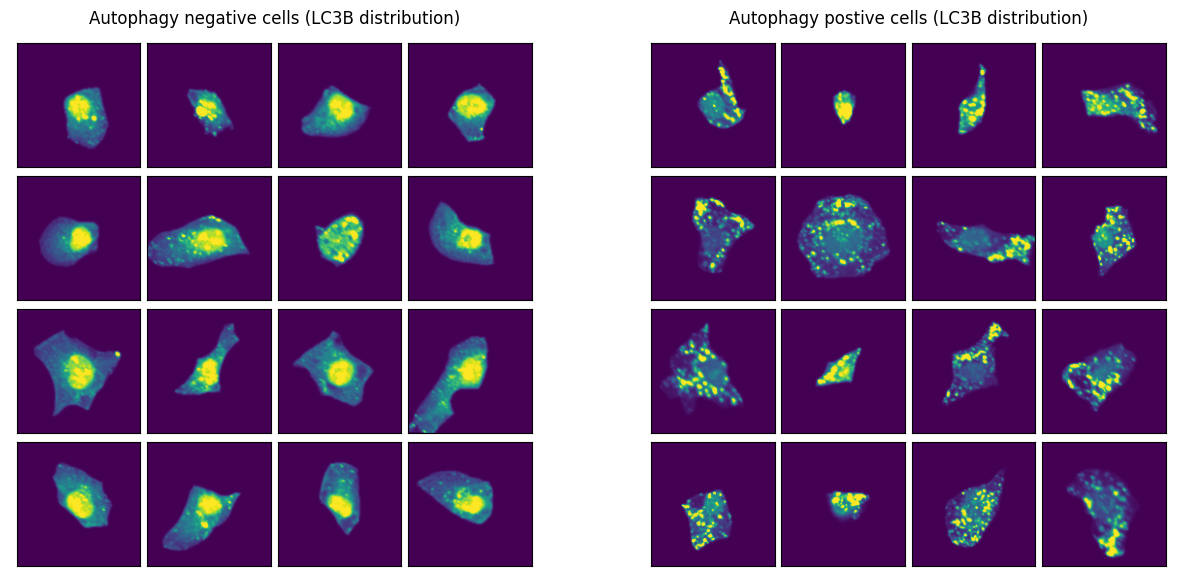

In [4]:
# get example images for positive and negative autophagy
num_rows, num_cols = 4, 4
n_cells = num_rows * num_cols
channel_of_interest = 4 # LC3B channel a key autophagosome marker

autophagy_positive_example = scportrait.io.read_h5sc(sc_datasets.filter(ulabels__name="WT").filter(ulabels__name="14h Torin-1")[0].cache())
autophagy_negative_example = scportrait.io.read_h5sc(sc_datasets.filter(ulabels__name="WT").filter(ulabels__name="untreated")[0].cache())

# create a figure with two panels for negative and postive examples
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
scportrait.pl.cell_grid_single_channel(autophagy_negative_example, select_channel=channel_of_interest, ax=axes[0], title="Autophagy negative cells (LC3B distribution)", show_fig=False)
scportrait.pl.cell_grid_single_channel(autophagy_positive_example, select_channel=channel_of_interest, ax=axes[1], title="Autophagy postive cells (LC3B distribution)", show_fig=False)

## Train ML model

In [5]:
# load data
wt_cells_afs = featurized_datasets.filter(ulabels__name="WT", is_latest = True).distinct().one()
features_wt = wt_cells_afs.load()

ko_cells_afs = featurized_datasets.filter(ulabels__name="EI24KO", is_latest = True).distinct().one()
features_ko = ko_cells_afs.load()

In [6]:
# split data into training and testing
data_train, data_test = train_test_split(features_wt, test_size=0.4, random_state=42)

# prepare data for model training by removing columns we don't want to train on
_data_train = data_train.drop(columns=["dataset", "cell_id"])
_data_train = _data_train.drop(columns=[col for col in data_train.columns if "mCherry" in col]) # subset to only include features from our channel of interest

_data_test = data_test.drop(columns=["dataset", "cell_id"])
_data_test = _data_test.drop(columns=[col for col in data_test.columns if "mCherry" in col]) # subset to only include features from our channel of interest

# Separate features and target
X_train = _data_train.drop("class", axis=1)
y_train = _data_train["class"]

X_test = _data_test.drop("class", axis=1)
y_test = _data_test["class"]

# Train model
clf = RandomForestClassifier(**rfc_params)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)
y_scores = clf.predict_proba(X_test)

data_test["predicted_class"] = y_pred
data_test["prob_class1"] = y_scores[:, 1]

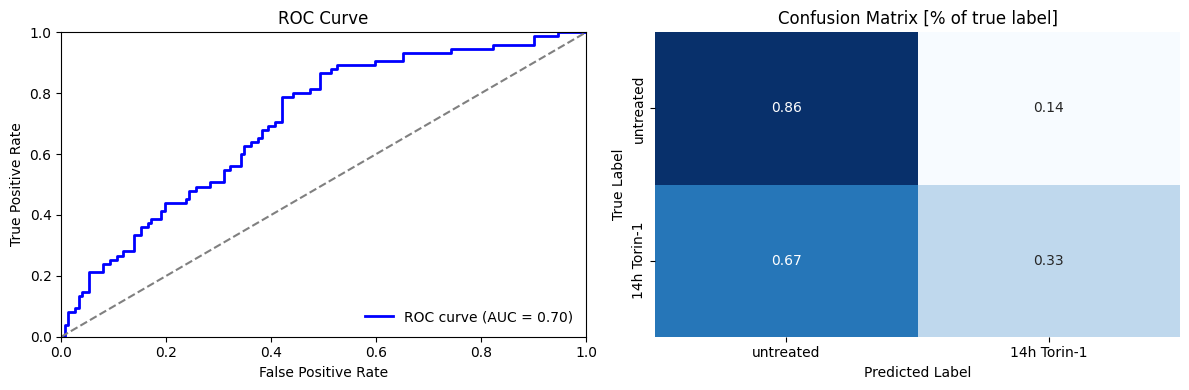

In [7]:
# compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
labels = np.unique(y_test)
labels = [class_lookup[label] for label in labels]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the confusion matrix and ROC Curve
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels, ax = axes[1], cbar = False)
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")
axes[1].set_title("Confusion Matrix [% of true label]")

axes[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.0])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc='lower right', frameon = False)
fig.tight_layout()

Considering that it was only trained on very few input images, our classifier performs well with an AUC of 0.77. This is already much better than a random classifier which we would expect to have an AUC of 0.5.

However, since the AUC is < 1, our model is still appears to make some mistakes. We can further investigate this through a confusion matrix. Our classifier is performing well at recognizing autophagy negative cells, correctly identifying 92% of the examples in our dataset. Unfortunately, the classifier is not yet very good at correctly identifying autophagy-postive cells. Less than 50% of these examples are classified correctly.

Let's visualize some of the cells from each class to see if we can gain some insights into what our model is doing.

/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/ipykernel_24891/831650762.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  _sc_data.obs["score"] = _selected_cells.prob_class1.values
/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/ipykernel_24891/831650762.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  _sc_data.obs["score"] = _selected_cells.prob_class1.values
/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/ipykernel_24891/831650762.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  _sc_data.obs["score"] = _selected_cells.prob_class1.values
/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/ipykernel_24891/831650762.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  _sc_data.obs["score"] = _selected_cells.prob_class1.values
/var/folders/35/p4c58_4n

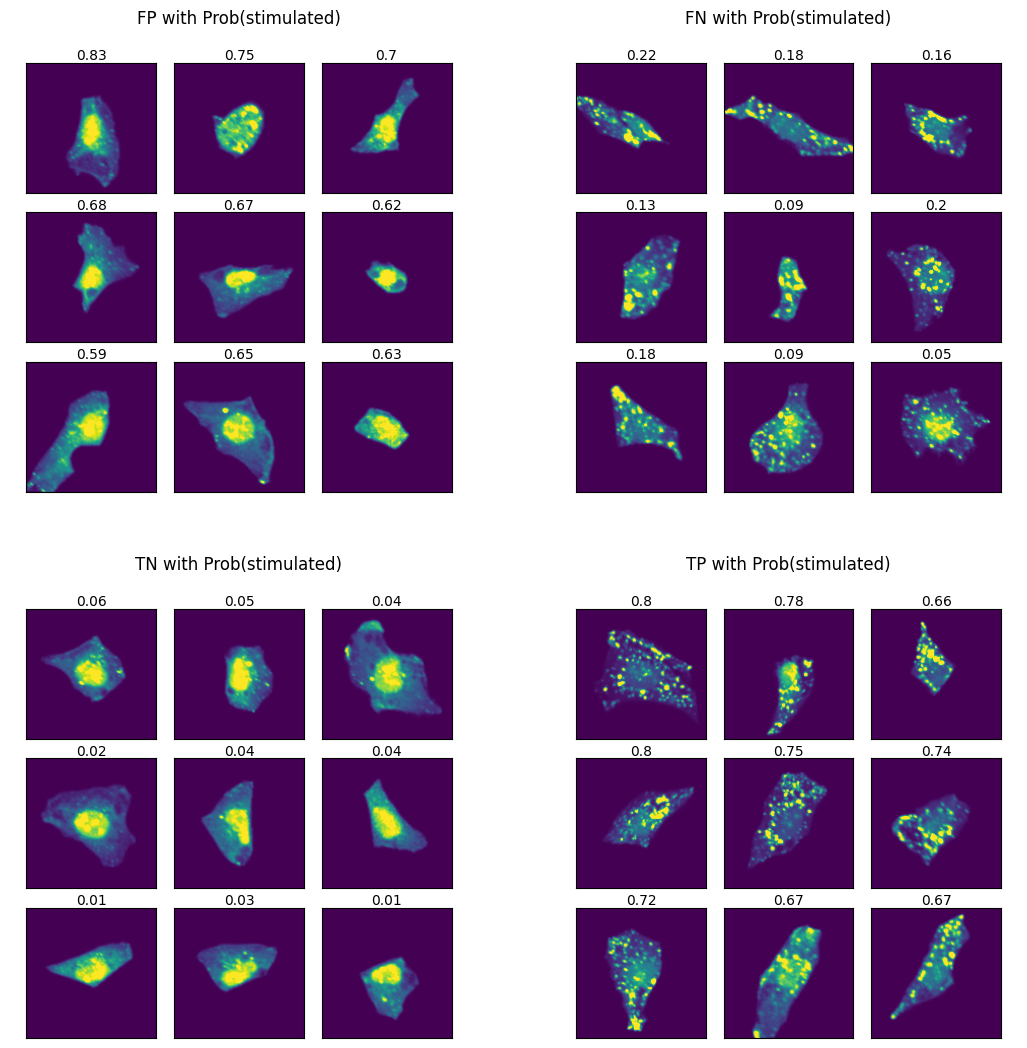

In [8]:
# visualize some example cells with classification scores from the test dataset
num_rows, num_cols = 3, 3
n_cells = num_rows * num_cols
channel_of_interest = 4 # LC3B channel a key autophagosome marker

# annotate dataset with TP, TN, FN, FP
data_test["FP"] = (data_test["class"] == 0) & (data_test["predicted_class"] == 1)
data_test["FN"] = (data_test["class"] == 1) & (data_test["predicted_class"] == 0)
data_test["TP"] = (data_test["class"] == 1) & (data_test["predicted_class"] == 1)
data_test["TN"] = (data_test["class"] == 0) & (data_test["predicted_class"] == 0)

# get example cells for each class
cells_TP = data_test[data_test.TP].sort_values("prob_class1", ascending=False).head(n_cells)
cells_TN = data_test[data_test.TN].sort_values("prob_class1", ascending=False).tail(n_cells)
cells_FN = data_test[data_test.FN].sort_values("prob_class1", ascending=False).tail(n_cells)
cells_FP = data_test[data_test.FP].sort_values("prob_class1", ascending=False).head(n_cells)

cell_sets = {"TP": _get_cells(cells_TP), "TN": _get_cells(cells_TN), "FN": _get_cells(cells_FN), "FP": _get_cells(cells_FP)}

# make the plot
n_panel_rows = 2
n_panel_cols = 2
fig, axes = plt.subplots(nrows=n_panel_rows, ncols=n_panel_cols, figsize=(13, 13))

for j in range(n_panel_rows):
    for i in range(n_panel_cols):
        ax = axes[j, i]
        title, cells = cell_sets.popitem()
        scportrait.pl.cell_grid_single_channel(cells, cell_ids = cells.obs.cell_id, cell_labels = cells.obs.score.round(2).values, select_channel=channel_of_interest, ax=ax, title=f"{title} with Prob(stimulated)", show_fig=False)

Looking at the False Positives (i.e. cells that look stimulated despite not having been stimulated) we can see two different types of cells
1. Very small cells that don't show any visible autophagosomes
2. Larger cells that clearly show some autophagosomes

The cells of type 1 look like they are the result of our model making mistakes, but the cells of type 2 look much more similar to TP cells than TN cells. Based on literature we know that cells can under go spontaneous autophagy even in the absence of Torin-1, for example as a result of nutrient scarcity. Since our class labelling is just based on the fact that the cells have not been treated with Torin-1, we would actually be annotating these cells incorrectly. In these cases our model does not actually make a mistake, but has in fact uncovered mislabelled examples in the dataset.

Looking at the False Negatives (i.e. cells that the model identifies as having been unstimulated despite having been stimulated) the cells appear homogenous and look more comparable to the True Positive Population. So in this case it seems our model is making a mistake. 

Before applying this model in a biological context, we would therefore probably need to invest some more time and effort into improving it! 

We could for example:
1. Train our model on more input data to make it more robust
2. Perform a pre-screening of our training data to ensure we remove any incorrectly labelled cells
3. Improve the image features we are training our model on to better reflect the biology we are interested in

If you are interested in finding out more you can check out the [original paper](https://www.biorxiv.org/content/10.1101/2023.06.01.542416v1) for these data where the authors trained a deep learning model to classify these cells with a much higher accuracy. 

## Investigate the *EI24* KO cells

Now lets take a look at the EI24-deficient cells.


In [9]:
data_ko = features_ko.drop(columns=["dataset", "cell_id"])
data_ko = data_ko.drop(columns=[x for x in data_ko.columns if "mCherry" in x])
X_ko = data_ko.drop("class", axis=1)
y_true = data_ko["class"]
predictions_ko = clf.predict(X_ko)

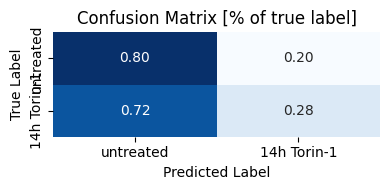

In [10]:
# compute confusion matrix
cm = confusion_matrix(y_true, predictions_ko)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
labels = np.unique(y_test)
labels = [class_lookup[label] for label in labels]

# Plot the confusion matrix and ROC Curve
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 2))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels, ax = axes, cbar = False)
axes.set_xlabel("Predicted Label")
axes.set_ylabel("True Label")
axes.set_title("Confusion Matrix [% of true label]")
fig.tight_layout()

Interestingly, our model classifies a high percentage of stimulated *EI24*-KO cells as being unstimulated. Lets take a look at the images again.

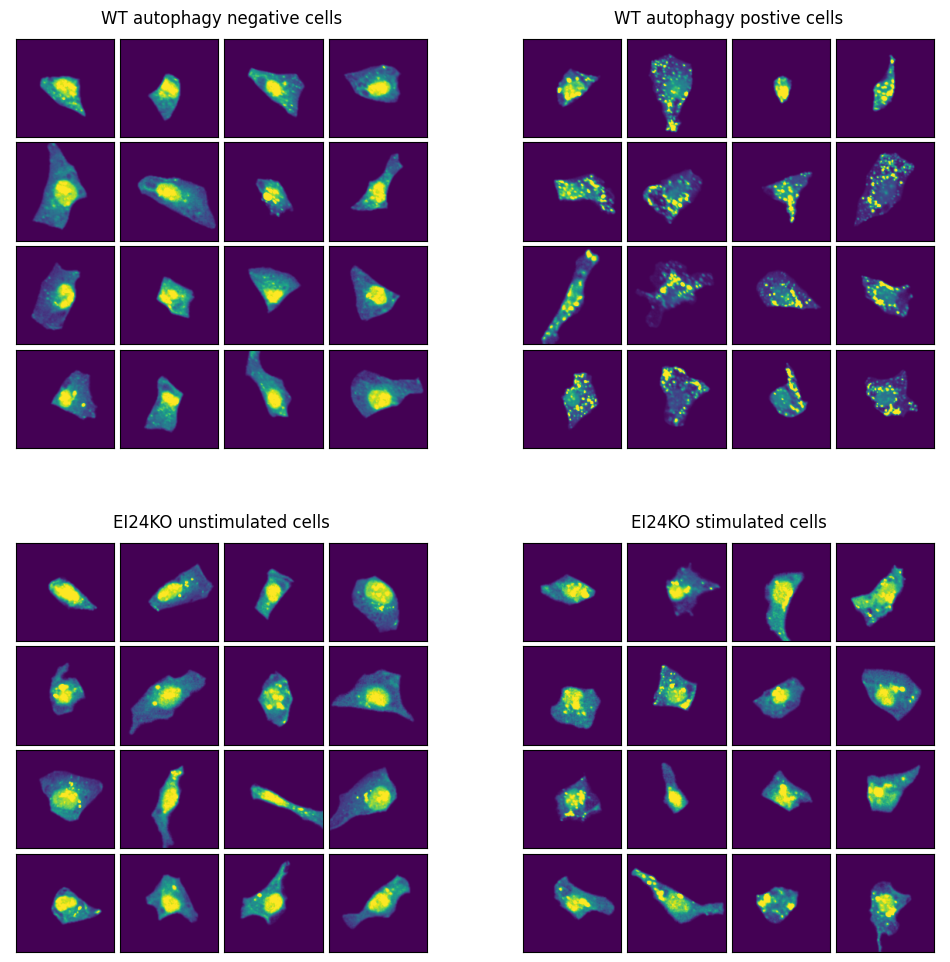

In [11]:
# compare WT And EI24KO cells
num_rows, num_cols = 4, 4
n_cells = num_rows * num_cols
channel_of_interest = 4 # LC3B channel a key autophagosome marker

EI24_KO_stimulated = scportrait.io.read_h5sc(sc_datasets.filter(ulabels__name="EI24KO").filter(ulabels__name="14h Torin-1")[0].cache())
EI24_KO_unstimulated = scportrait.io.read_h5sc(sc_datasets.filter(ulabels__name="EI24KO").filter(ulabels__name="untreated")[0].cache())

# create a figure with two panels for negative and postive examples
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
scportrait.pl.cell_grid_single_channel(autophagy_negative_example, select_channel=channel_of_interest, ax=axes[0, 0], title="WT autophagy negative cells", show_fig=False)
scportrait.pl.cell_grid_single_channel(autophagy_positive_example, select_channel=channel_of_interest, ax=axes[0, 1], title="WT autophagy postive cells", show_fig=False)
scportrait.pl.cell_grid_single_channel(EI24_KO_unstimulated, select_channel=channel_of_interest, ax=axes[1, 0], title="EI24KO unstimulated cells", show_fig=False)
scportrait.pl.cell_grid_single_channel(EI24_KO_stimulated, select_channel=channel_of_interest, ax=axes[1, 1], title="EI24KO stimulated cells", show_fig=False)

The *EI24* KO cells have fewer LC3 puncta, and seem to show a defect in the formation of autophagosomes. Even when stimulated, *EI24* KO cells look comparable to unstimated cells. In this instance, out model appears to correctly identify the biological effect of a deficiency in the *EI24* gene.

## Track cells back to see them in their original context

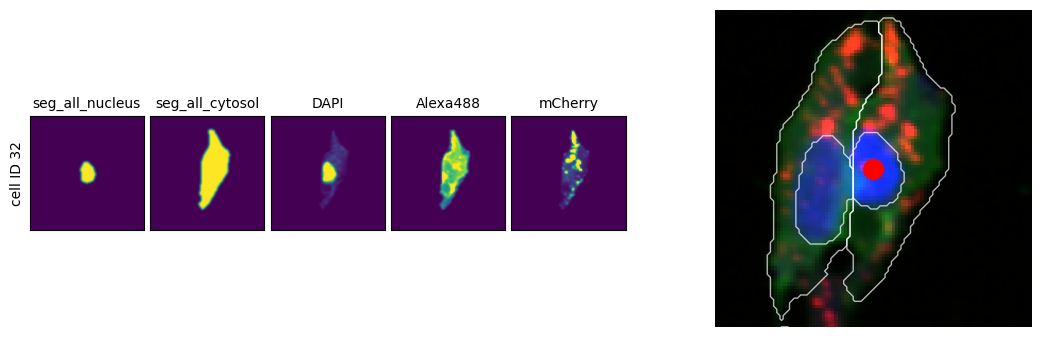

In [12]:
# select a random cell from the WT  dataset
cell = features_wt.sample(1, random_state = 42)
dataset = cell["dataset"].values[0]
cell_id = cell["cell_id"].values[0]

# get spatialdata object and single-cell image dataset
sdata = ln.Artifact.get(key = ln.Artifact.get(dataset).key.replace("single_cell_data.h5ad", "spatialdata.zarr")).load()
single_cell_images = scportrait.io.read_h5sc(ln.Artifact.get(dataset).cache())

#lookup location of cell of interest
x, y = sdata["centers_seg_all_nucleus"].compute().loc[cell_id, :]

# plot single-cell images and spatial context
fig, axs = plt.subplots(1, 2, figsize=(12, 3.5))
scportrait.pl.cell_grid_multi_channel(single_cell_images, cell_ids = cell_id, axs = axs[0], show_fig = False)
scportrait.pl.plot_segmentation_mask(sdata, masks = ["seg_all_nucleus", "seg_all_cytosol"], select_region = (x, y), max_width = 100, axs = axs[1], show_fig = False)
axs[1].scatter(x, y, color = "red", s = 200,) # plot red dot on top of selected cell
fig.tight_layout()

In [13]:
ln.finish()

• please hit CMD + s to save the notebook in your editor . ✓
→ finished Run('l2hUOJGf') after 30s at 2025-03-20 11:55:08 UTC
→ go to: https://lamin.ai/scportrait/examples/transform/OgvkhEc7xWDi0006
→ to update your notebook from the CLI, run: lamin save /Users/sophia/Documents/GitHub/lamin-usecases/docs/imaging4.ipynb
